In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#load datasets

In [2]:
customers = pd.read_csv(r"C:\Users\rakeek mirza\OneDrive\Desktop\zephr\zephyrprojects\Zeotap\Customers.csv")
customers

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07
196,C0197,Christina Harvey,Europe,2023-03-21
197,C0198,Rebecca Ray,Europe,2022-02-27
198,C0199,Andrea Jenkins,Europe,2022-12-03


In [3]:
transactions = pd.read_csv(r"C:\Users\rakeek mirza\OneDrive\Desktop\zephr\zephyrprojects\Zeotap\Transactions.csv")
transactions

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68
...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86


### Data preparation.

In [4]:
#merging

In [5]:
customer_transactions = pd.merge(transactions, customers, on="CustomerID", how="inner")

In [6]:
#Aggregating data by creatng metrics

In [8]:
customer_summary = customer_transactions.groupby("CustomerID").agg(
    TotalRevenue=("TotalValue", "sum"),
    TransactionCount=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean"),
    Region=("Region", "first") 
).reset_index()

In [9]:
#encoding categerical data using labelencoder()

In [10]:
encoder = LabelEncoder()
customer_summary["RegionEncoded"] = encoder.fit_transform(customer_summary["Region"])
customer_summary.drop("Region", axis=1, inplace=True)

In [11]:
#Standardize the Data

In [12]:
scaler = StandardScaler()
features = ["TotalRevenue", "TransactionCount", "AvgTransactionValue", "RegionEncoded"]
customer_summary_scaled = scaler.fit_transform(customer_summary[features])

### Clustering

In [13]:
# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [28]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_summary["Cluster"] = kmeans.fit_predict(customer_summary_scaled)

In [29]:
#cluster evaluation.
db_index = davies_bouldin_score(customer_summary_scaled, customer_summary["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.2322768822445056


### Visualization

In [17]:
from sklearn.decomposition import PCA
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

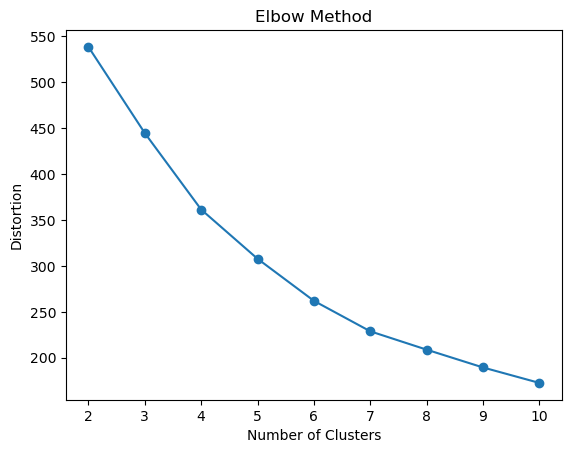

In [22]:
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_summary_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(2, 11), distortions, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.title("Elbow Method")
plt.show()

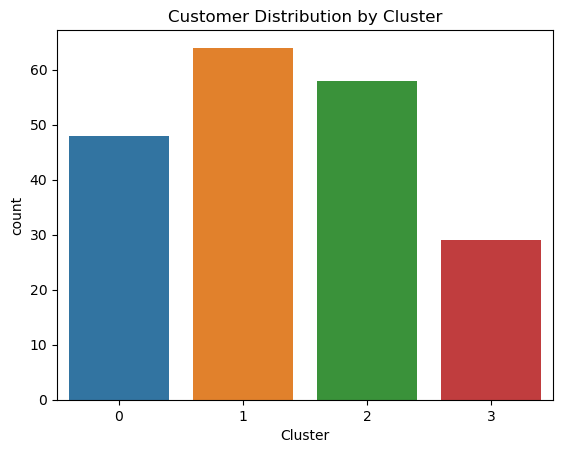

In [23]:
sns.countplot(x="Cluster", data=customer_summary)
plt.title("Customer Distribution by Cluster")
plt.show()

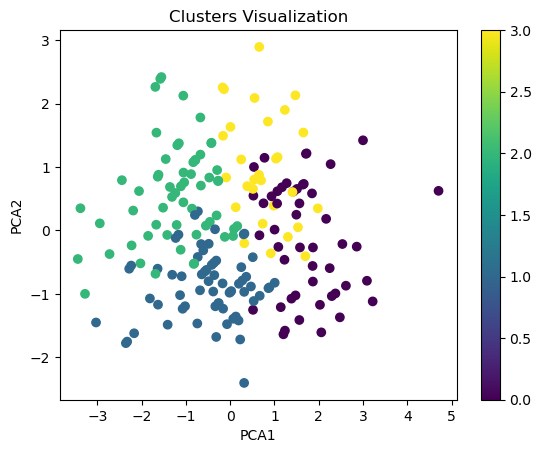

In [24]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_summary_scaled)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=customer_summary["Cluster"], cmap="viridis")
plt.colorbar()
plt.title("Clusters Visualization")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [32]:
cluster_summary = customer_summary.groupby("Cluster").agg(
    AvgTotalRevenue=("TotalRevenue", "mean"),
    AvgTransactionCount=("TransactionCount", "mean"),
    AvgTransactionValue=("AvgTransactionValue", "mean"),
    CustomerCount=("CustomerID", "count")
).reset_index()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
   Cluster  AvgTotalRevenue  AvgTransactionCount  AvgTransactionValue  \
0        0      5772.168333             7.791667           749.321825   
1        1      2703.956094             4.703125           579.952719   
2        2      1952.126034             3.500000           572.246309   
3        3      4367.413103             4.206897          1053.577540   

   CustomerCount  
0             48  
1             64  
2             58  
3             29  
